In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
data_path = '../data/CALC_STRAIGHT/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	232


In [14]:
A = pd.read_csv('../data/STRAIGHT_STEP_FREQ.csv')
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,Type
0,N-15-1-Char00part2seg-0.csv,24774.0,25295.0,7.0,7.0,0.017,522.0,8.874,0.788821,0.788821,N
1,N-15-1-Char00part3seg-0.csv,25433.0,26395.0,12.0,13.0,0.017,963.0,16.371,0.733003,0.794087,N
2,N-04-1-Char00part7seg-3.csv,57701.0,59747.0,13.0,14.0,0.008,2047.0,16.376,0.793845,0.854910,N
3,A-736123-Char00part1seg-0.csv,2900.0,4287.0,18.0,18.0,0.017,1388.0,23.596,0.762841,0.762841,A
4,N-15051994-Char00part2seg-0.csv,18500.0,20250.0,13.0,13.0,0.008,1751.0,14.008,0.928041,0.928041,N


In [5]:
text_file = open('../data/JointNamesCalc.txt', "r")
joint_names_calc = text_file.read().split('\n')
len(joint_names_calc)

61

In [6]:
spine_joints = ['Spine3','Spine2','Spine1','Spine','Hips']
spine_joints_ind = np.zeros([len(spine_joints),1])
cc = 0
for c in spine_joints:
    spine_joints_ind[cc] = joint_names_calc.index(c) + 1
    cc+=1
spine_joints_ind

array([[18.],
       [19.],
       [20.],
       [21.],
       [ 1.]])

In [7]:
def euclidean(df):
    N = np.size(df,axis=0)
    dist = np.zeros((N-1))
    for n in range(1,N):
        dist[n-1] = ((df.iloc[n,0]-df.iloc[n-1,0])**2+(df.iloc[n,1]-df.iloc[n-1,1])**2+(df.iloc[n,2]-df.iloc[n-1,2])**2)**(1/2)
    return dist
        

In [8]:
def curve_len(df):
    return ((df.iloc[-1,0]-df.iloc[0,0])**2+(df.iloc[-1,1]-df.iloc[0,1])**2)**(1/2)

In [9]:
def mean_xyz(df):
    avg = pd.DataFrame()
    for dim in ['x','y','z']:
        dim_cols = [s for s in df.columns.to_list() if dim in s]
        dim_df = df.filter(dim_cols,axis=1)
        avg[dim] = np.mean(dim_df,axis=1)
    return avg

In [10]:
def module(joint):
    N = np.size(joint,axis=0)
    module = np.zeros((N))
    for n in range(0,N):
        module[n] = ((joint.iloc[n,0])**2+(joint.iloc[n,1])**2+(joint.iloc[n,2])**2)**(1/2)
    return module

A-03-1-Char00part4seg-0.csv


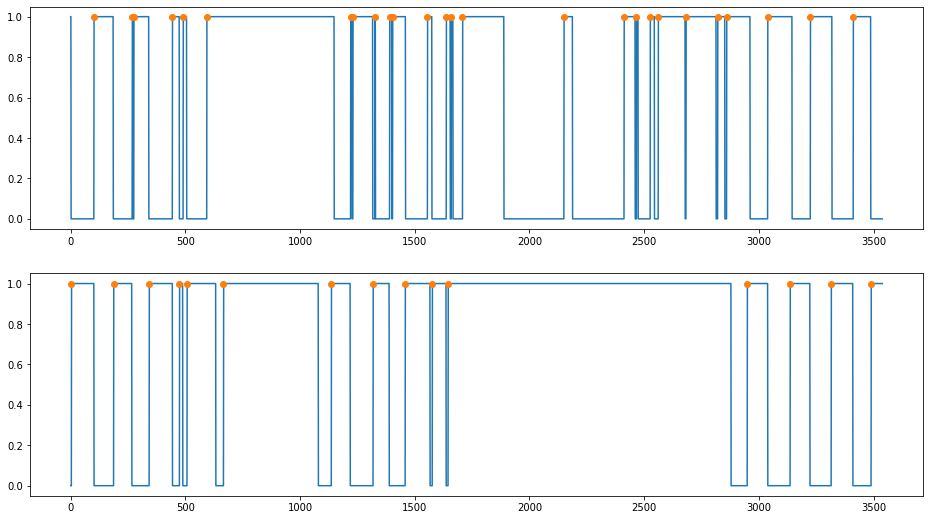

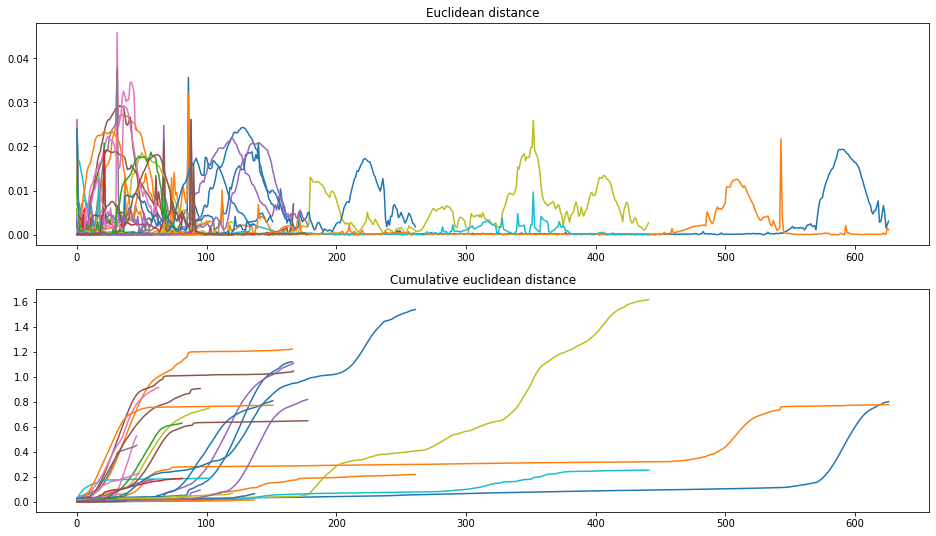

In [15]:
for file in files:
    file = 'A-03-1-Char00part4seg-0.csv'
    step_len_L = np.empty(0)
    step_len_R = np.empty(0)

    cur_len_L = np.empty(0)
    cur_len_R = np.empty(0)
    
    sd = np.empty(0)
    sd_x = np.empty(0)
    sd_y = np.empty(0)
    sd_z = np.empty(0)

    print(file)
    
    df = pd.read_csv(data_path + file)
    position_cols = [s for s in df.columns.to_list() if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    accel_cols = [s for s in df.columns.to_list() if "A" in s]
    adf = df.filter(accel_cols,axis=1)
    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
           
    peaksL = np.where(np.diff(df.contactL)>0)[0]
    peaksR = np.where(np.diff(df.contactR)>0)[0]
    
    fig,ax = plt.subplots(2,1,figsize=(16,9))
    ax[0].plot(df.contactL)
    ax[0].plot(peaksL,np.ones_like(peaksL),'o')
    ax[1].plot(df.contactR)
    ax[1].plot(peaksR,np.ones_like(peaksR),'o')
    
    
    if len(peaksL) > len(peaksR):
        steps = peaksL
    else:
        steps = peaksR
        
    # Exclude first and last step (before or after turn)
    start = steps[0]
    steps = steps[1:-2]
    end = steps[1]
    
    fig,ax = plt.subplots(2,1,figsize=(16,9))
    
    for step in steps:
        #print(step)
        end = step
        # select actual step
        x = xdf.loc[start:end,:] # position only
        X = df.loc[start:end,:]  # everything
        a = adf.loc[start:end,:]
        
        accel_cols = a.columns.to_list()
        AA = pd.DataFrame()
        for joint in range(1,60):
            joint_cols = []
            for col in accel_cols:
                if str(joint) in col:
                    joint_cols.append(accel_cols.index(col))
            this_joint = a.filter(a.columns[joint_cols],axis=1)
            AA[str(joint)] = module(this_joint)
        '''
        # TODO FEATURES TO CALCULATE:                               NEEDED
DONE    1] step length by euclidean + XY first/last                 position of foot
DONE    2] step length by lenght of curve                           position of foot
DONE    3] standard deviation of spine / center of mass             position of spine/COM
        4] % of frequency in frequency bands                        acceleration  
        5] coordination of limbs L hand + R foot / R hand + L foot  position of foots + hands, processed by two steps
        '''
        # FOOTS
        leftleg_cols = []
        for col in x.columns.to_list():
            if '07' in col:
                leftleg_cols.append(x.columns.to_list().index(col))
        rightleg_cols = []
        for col in x.columns.to_list():
            if '04' in col:
                rightleg_cols.append(x.columns.to_list().index(col))
        foot_L_df = x.filter(x.columns[leftleg_cols],axis=1)
        foot_R_df = x.filter(x.columns[rightleg_cols],axis=1)
        
        # HANDS
        lefthand_cols = []
        for col in x.columns.to_list():
            if '15' in col:
                lefthand_cols.append(x.columns.to_list().index(col))
        righthand_cols = []
        for col in x.columns.to_list():
            if '11' in col:
                righthand_cols.append(x.columns.to_list().index(col))
        hand_L_df = x.filter(x.columns[lefthand_cols],axis=1)
        hand_R_df = x.filter(x.columns[righthand_cols],axis=1)
        
        # SPINE
        spine_cols = []
        for c in spine_joints_ind:
            for col in x.columns.to_list():
                if c<10:
                    name = '0' + str(int(c)) + '-'
                else:
                    name = str(int(c)) + '-'
                if col.startswith(name):
                    spine_cols.append(x.columns.to_list().index(col))
        spine_df = x.filter(x.columns[spine_cols],axis=1)
        
        COM = mean_xyz(spine_df)
        COMmod = module(COM)
        
        ######### STEP LENGTH ############
        
        distL = euclidean(foot_L_df)
        distR = euclidean(foot_R_df)
        
        step_len_L = np.append(step_len_L,np.sum(distL))
        step_len_R = np.append(step_len_R,np.sum(distR))
        
        
        ax[0].plot(distL)
        ax[0].plot(distR)
        ax[0].set_title('Euclidean distance')

        ax[1].plot(np.cumsum(distL))
        ax[1].plot(np.cumsum(distR))
        ax[1].set_title('Cumulative euclidean distance')
        
        
        distL = curve_len(foot_L_df)
        distR = curve_len(foot_R_df)
        
        cur_len_L = np.append(cur_len_L,distL)
        cur_len_R = np.append(cur_len_R,distR)
        
        ######### COM STANDARD DEVIATION ############
        
        sd = np.append(sd,np.std(COMmod))
        sd_x = np.append(sd_x,np.std(COM.x))
        sd_y = np.append(sd_y,np.std(COM.y))
        sd_z = np.append(sd_z,np.std(COM.z))
        
        ######### % FREQUENCY IN FREQ BANDS ############
        # input A[joint -> module of acceleration], Tsampling, freq. bands
        # outpus F[joint -> % of energy in band]
        
        ######### 
        
        start = end
        
    A.loc[A['File'] == file,'StepLenL'] = np.median(step_len_L)
    A.loc[A['File'] == file,'StepLenR'] = np.median(step_len_R)
    
    A.loc[A['File'] == file,'CurLenL'] = np.median(cur_len_L)
    A.loc[A['File'] == file,'CurLenR'] = np.median(cur_len_R)
    break

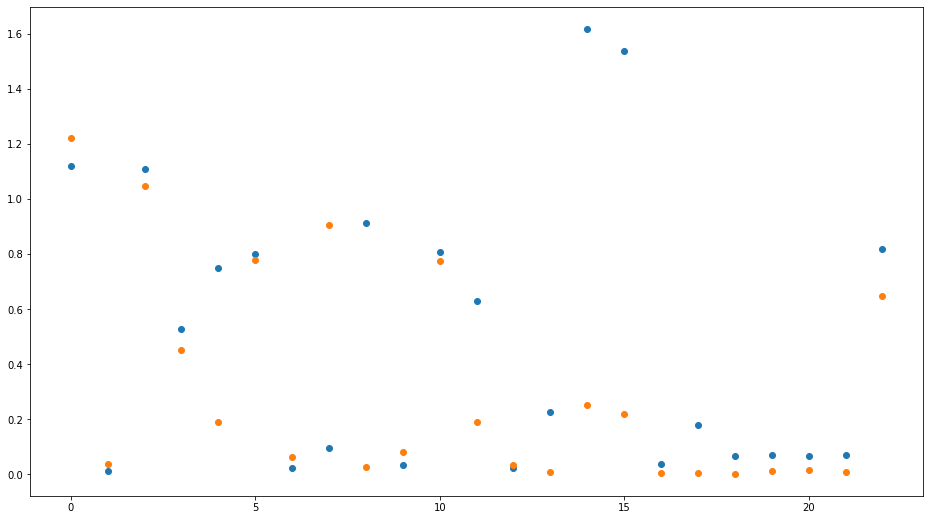

In [16]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(step_len_L,'o')
ax.plot(step_len_R,'o')

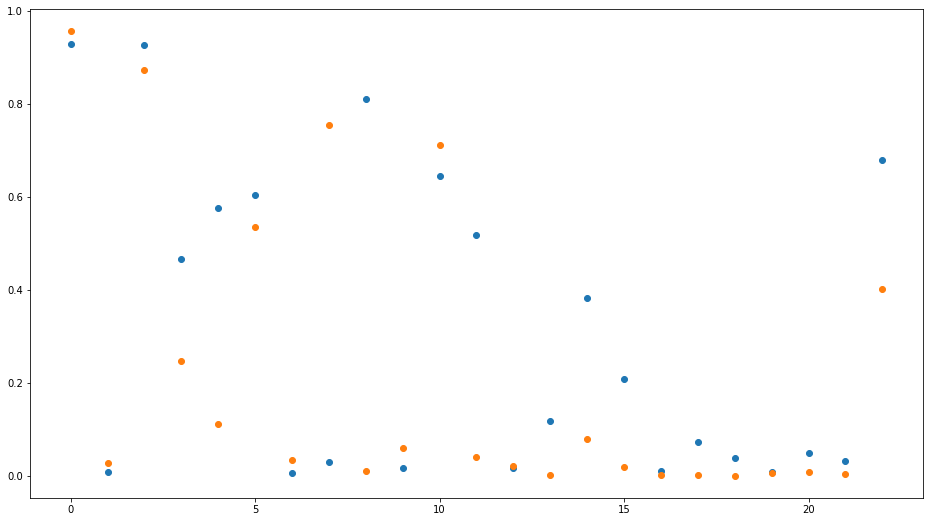

In [17]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(cur_len_L,'o')
ax.plot(cur_len_R,'o')

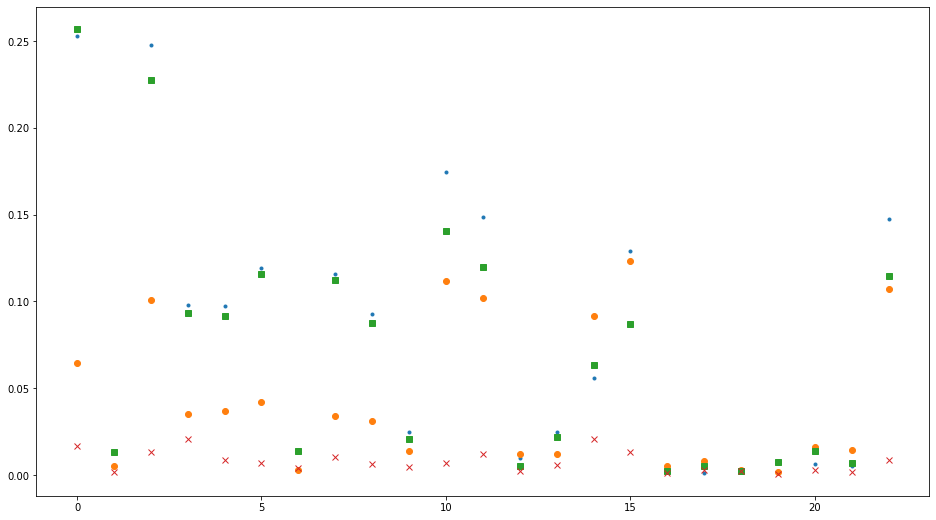

In [18]:
fig,ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(sd,'.')
ax.plot(sd_x,'o')
ax.plot(sd_y,'s')
ax.plot(sd_z,'x')
